#<h1><center>  Tarea 6 EL7008 </center></h1>
## <h1><center> Segmentación semántica en dataset Kitti </center></h1>

**Integrante**: 

Diego Pincheira

**Profesor**: 

Javier Ruiz del Solar

**Auxiliar**: 

Patricio Loncomilla

**Ayudantes**:  
Juan Pablo Cáceres

Hans Starke

Javier Smith

José Villagrán
                

**Fecha de Entrega**:

07 de Enero de 2021

# Introducción



El presente informe aborda el entrenamiento y verificación de funcionamiento de un **sistema de segmentación semántica basado en U-net**. Para ello, se utilizará la base de datos **Kitti** (disponible en el sitio web  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip), la cual corresponde a **imágenes capturadas por un vehículo en movimiento**. Este dataset se compone de 200 imágenes de entrenamiento etiquetadas pixel a pixel, y 200 imágenes sin etiquetar, siendo 12 el número de clase de etiquetas posibles. Se entrenará la red U-net, evaluando su posterior desempeño con una colección de imágenes tanto del conjunto de entrenamiento como de prueba.

Se analizará el dataset Kitti, describiendo su estructura e implementando una función que permita manejar la información que contiene. Se dividirá el dataset en dos conjuntos, entrenamiento y prueba, y se realizará un split a los datos de entrenamiento para poder validar el desempeño del clasificador. Posteriormente se adaptará el código de entrenamiento de la U-Net provisto por el cuerpo docente para poder procesar el dataset objetivo, y se entrenará la red con los datos de entrenamiento, en conjunto de registrar la función de pérdida de la red para observar su desempeño. Luego, se evaluará dos instancias de la red (una al entrenarse durante 2 épocas y otra durante 7 épocas), observando la segmentación realizada a 10 imágenes aleatorias siendo 5 provenientes del conjunto de entrenamiento, y 5 del conjunto de prueba. Por último, se analizarán los resultados registrados, obteniendo finalmente conclusiones a partir de dichos análisis.

# Desarrollo

### Carga de datos:


Carga de repositorio

In [ ]:
!git clone https://github.com/milesial/Pytorch-UNet

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 349, done.
remote: Total 349 (delta 0), reused 0 (delta 0), pack-reused 349
Receiving objects: 100% (349/349), 47.35 MiB | 38.94 MiB/s, done.
Resolving deltas: 100% (177/177), done.


Carga de Dataset

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2021-01-08 00:24:38--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.47.131
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.47.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  19.5MB/s    in 17s     

2021-01-08 00:24:55 (18.9 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]



In [ ]:
from IPython.display import clear_output

Se descomprime el dataset

In [ ]:
!unzip data_semantics.zip
clear_output()
print('listo!')

listo!


### Librerías

Se importan las librerías necesarias para la elaboración de los códigos.

In [ ]:
import argparse
import logging
import os
import sys

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm
import sys
sys.path.append('/content/Pytorch-UNet')
from eval import eval_net
from unet import UNet

import random
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms

from utils.data_vis import plot_img_and_mask
from utils.dataset import BasicDataset
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from utils.dataset import BasicDataset
from torch.utils.data import DataLoader, random_split

from os.path import splitext
from os import listdir
from glob import glob
from torch.utils.data import Dataset
import logging
from PIL import Image
!pip install ipython-autotime
%load_ext autotime

time: 136 µs (started: 2021-01-08 00:25:05 +00:00)


In [ ]:
dir_img = './training/image_2/'
dir_mask = './training/semantic/'
dir_checkpoint = './'
dir_testing = './testing/image_2/'

time: 2.35 ms (started: 2021-01-08 00:25:05 +00:00)


## Descripción del Dataset

El Dataset de segmentación semántica Kitti para evaluación consiste en una secuencia de 400 imágenes, de las cuales 200 poseen un mapa semántico, el cual contiene información respecto a **los tipos de elementos presentes en la imagen objetivo**, mientras que el resto de las imágenes consiste en elementos de prueba para algoritmos que permitan extrapolar máscaras, siendo estos entrenados a partir de los primeros 200 elementos.

Utilizando las máscaras semánticas, es posible ilustrar la distinción entre un vehículo, un peatón, un ciclista, y la calle, entre otros elementos. Uno de los principales usos de esta segmentación semántica es para la **conducción de vehículos autónomos**, entregando información respecto a que es lo que el vehículo percibe con los sensores, tomando decisiones respecto a dicha información.

Se ilustra a continuación tres ejemplos de la imagen de la secuencia y su máscara semántica correspondiente. En ellas se puede apreciar que se hace una distinción respecto a lo que se visualiza en la imagen: la calle se diferencia claramente de los vehículos, mientras que estos constrastan con elementos de fondo como lo son estructuras y veredas.

In [ ]:
Random_Sample = random.sample(os.listdir(dir_img), 3)

time: 1.13 ms (started: 2021-01-08 02:09:21 +00:00)


Imagen:  000087_10.png
Imagen RGB


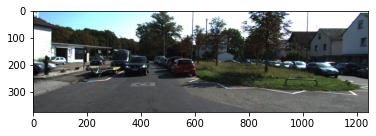

Máscara semántica de la imagen


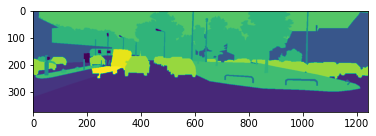

time: 336 ms (started: 2021-01-08 02:09:42 +00:00)


In [ ]:
print('Imagen: ',Random_Sample[0] )
print('Imagen RGB')
plt.imshow(Image.open(dir_img + Random_Sample[0]))
plt.show()
print('Máscara semántica de la imagen')
plt.imshow(Image.open(dir_mask + Random_Sample[0]))
plt.show()

Imagen:  000087_10.png
Imagen RGB


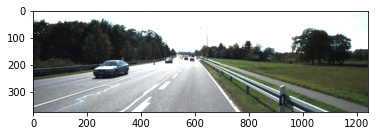

Máscara semántica de la imagen


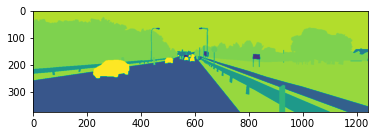

time: 329 ms (started: 2021-01-08 02:09:35 +00:00)


In [ ]:
print('Imagen: ',Random_Sample[0] )
print('Imagen RGB')
plt.imshow(Image.open(dir_img + Random_Sample[1]))
plt.show()
print('Máscara semántica de la imagen')
plt.imshow(Image.open(dir_mask + Random_Sample[1]))
plt.show()

Imagen:  000087_10.png
Imagen RGB


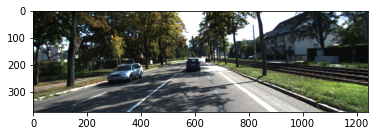

Máscara semántica de la imagen


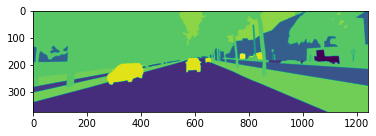

time: 328 ms (started: 2021-01-08 02:09:37 +00:00)


In [ ]:
print('Imagen: ',Random_Sample[0] )
print('Imagen RGB')
plt.imshow(Image.open(dir_img + Random_Sample[2]))
plt.show()
print('Máscara semántica de la imagen')
plt.imshow(Image.open(dir_mask + Random_Sample[2]))
plt.show()

## Funciones

### kitti_inverse_map1_channel()

Esta función, dada una imagen, realiza una conversión de los 31 valores posibles dentro de la máscara, reduciendolos a 11+1 etiquetas. Esta función ha sido proporcionada por el cuerpo docente.

In [ ]:
# Esta funcion debe ser copiada a una celda de colaboratory para poder usarla

from numba import jit
@jit(nopython=True)
def kitti_inverse_map_1channel(img):
  cmap = [
    (0, 0), #void (ignorable) 
    (4, 0),
    (5, 0),
    (6, 0),
    (7, 1), #road
    (8, 2), #sidewalk
    (9, 2),
    (10, 0), #rail truck (ignorable)
    (11, 3), #construction
    (12, 3),
    (13, 3),
    (14, 3),
    (15, 3),
    (16, 3),
    (17, 4), #pole(s)
    (18, 4),
    (19, 5), #traffic sign
    (20, 5),
    (21, 6), #vegetation
    (22, 6),
    (23, 7),
    (24, 8), #sky
    (25, 8),
    (26, 9), #human
    (27, 9),
    (28, 9),
    (29, 9),
    (30, 9),
    (31, 10), #train
    (32, 11), #cycle
    (33, 11)
  ]  

  arrmap = np.zeros( (34), dtype=np.int32 )

  for el in cmap:
    arrmap[el[0]] = el[1]

  val = np.ones((img.shape[0],img.shape[1]), dtype=np.int32) * -1

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      val[i,j] = arrmap[img[i,j]]
  return val

time: 1.55 s (started: 2021-01-08 00:25:13 +00:00)


## Clase KittiDataset

Esta clase permite original objetos que contienen información de las secuencias de fotos, en conjunto con sus respectivas máscaras (si es que las poseen). Esta clase se ha generado modificando la clase original BasicDataset proveniente del repositorio de U-Net, permitiendo entregar el par (imagen, máscara) al entregar un cierto índice de la imagen objetivo (entregando una lista vacía en luagr de la máscara si el dataset original proviene del conjunto de prueba).

In [ ]:
class KittiDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir,read_mask, scale=1, mask_suffix=''):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.read_mask = read_mask
        self.scale = scale
        self.mask_suffix = mask_suffix
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx + self.mask_suffix + '.*')
        img_file = glob(self.imgs_dir + idx + '.*')
        mask = Image.open(mask_file[0])
        img = Image.open(img_file[0])
        if self.read_mask == True:
          assert len(mask_file) == 1, \
              f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
          assert img.size == mask.size, \
              f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'

        if self.read_mask == True:
          mask = kitti_inverse_map_1channel(np.array(mask, dtype=np.int32))
          mask_torch = torch.from_numpy(mask).type(torch.IntTensor)
        else:
          mask_torch = []
        img = self.preprocess(img, self.scale)
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': mask_torch
        }


time: 41.4 ms (started: 2021-01-08 00:25:15 +00:00)


## U-Net: Entrenamiento

Se entrenará la red mediante 7 épocas con un batch de tamaño 1, guardando los checkpoints con el fin de utilizar estos posteriormente. Se guardarán los valores de la función de pérdida sobre el conjunto de validación, a la vez de evaluar este mismo cada vez que una época avance en un 50% (dos veces por época). El código base proviene de los archivos train.py y eval.py contenidos en el repositorio de la U-Net.

### Función de entrenamiento principal: train_net()

In [ ]:
def train_net(net,
              device,
              epochs=7,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=1.0,
              read_mask = True):
    
    net.to(device=device)
    dataset = KittiDataset(dir_img, dir_mask,read_mask, img_scale)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
    Val_Losses = []
    writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device.type}
        Images scaling:  {img_scale}
    ''')

    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
    if net.n_classes > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        Val_Loss_Per_Batch = []
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])
                global_step += 1
                if global_step % (n_train // (2 * batch_size)) == 0:
                    for tag, value in net.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                        writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                    val_score = eval_net(net, val_loader, device)
                    scheduler.step(val_score)
                    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)

                    if net.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('Loss/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', imgs, global_step)
                    if net.n_classes == 1:
                        writer.add_images('masks/true', true_masks, global_step)
                        writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.5, global_step)
                    Val_Loss_Per_Batch.append(val_score)

        Val_Losses.append(np.mean(Val_Loss_Per_Batch))
        if save_cp:
            try:
                os.mkdir(dir_checkpoint)
                logging.info('Created checkpoint directory')
            except OSError:
                pass
            torch.save(net.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()
    return Val_Losses


def get_args():
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('-e', '--epochs', metavar='E', type=int, default=5,
                        help='Number of epochs', dest='epochs')
    parser.add_argument('-b', '--batch-size', metavar='B', type=int, nargs='?', default=1,
                        help='Batch size', dest='batchsize')
    parser.add_argument('-l', '--learning-rate', metavar='LR', type=float, nargs='?', default=0.0001,
                        help='Learning rate', dest='lr')
    parser.add_argument('-f', '--load', dest='load', type=str, default=False,
                        help='Load model from a .pth file')
    parser.add_argument('-s', '--scale', dest='scale', type=float, default=0.5,
                        help='Downscaling factor of the images')
    parser.add_argument('-v', '--validation', dest='val', type=float, default=10.0,
                        help='Percent of the data that is used as validation (0-100)')

    return parser.parse_args()

time: 127 ms (started: 2021-01-08 00:25:15 +00:00)


### Entrenamiento de la red

In [ ]:
net = UNet(n_channels=3, n_classes=12)
logging.info(f'Network:\n'
              f'\t{net.n_channels} input channels\n'
              f'\t{net.n_classes} output channels (classes)\n'
              f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')

net.cuda()
cuda = torch.device('cuda')
Val_Loss = train_net(net=net,
              device=cuda)

Epoch 7/7: 100%|██████████| 180/180 [01:32<00:00,  1.95img/s, loss (batch)=0.384]

time: 10min 38s (started: 2021-01-08 00:58:31 +00:00)


### Gráfico de la evolución de la función de pérdida

Utilizando el **promedio de la función de pérdida en cada época**, se grafica la evolución de la misma a lo largo de las épocas de entrenamiento.

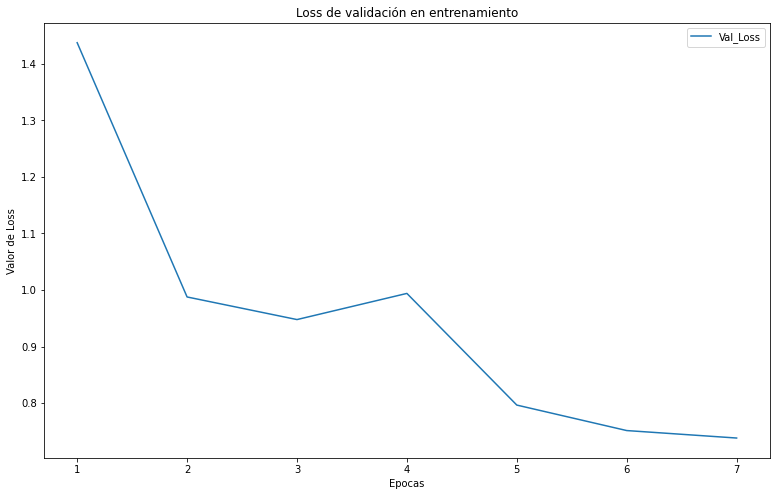

time: 160 ms (started: 2021-01-08 01:20:46 +00:00)


In [ ]:
X_Axis = np.linspace(1, len(Val_Loss),num=len(Val_Loss))
plt.figure(figsize=(13,8))
plt.plot(X_Axis,Val_Loss)
plt.xlabel('Épocas')
plt.ylabel('Valor de Loss')
plt.title('Loss de validación en entrenamiento')
plt.legend(['Val_Loss'])
plt.show()

Es posible apreciar que, para 7 épocas, **no se presenta un sobreajuste de la red**.

## U-Net: Predicción

Se crean dos objetos de KittiDataset():


*   train_dataset contiene la información correspondiente al conjunto de entrenamiento
*   test_dataset contiene la información correspondiente al conjunto de prueba



In [ ]:
train_dataset = KittiDataset(dir_img, dir_mask,True, scale=1)
test_dataset = KittiDataset(dir_testing, dir_mask,False, scale=1)
Lista_Indices_Train = np.linspace(0,len(train_dataset)-1,num=len(train_dataset))
Lista_Indices_Test = np.linspace(0,len(test_dataset)-1,num=len(test_dataset))

time: 6.02 ms (started: 2021-01-08 01:10:51 +00:00)


### Función de predicción principal: predict_img()

In [ ]:
def predict_img(net,
                full_img,
                device,
                scale_factor=1,
                out_threshold=0.5,
                read_mask = False):
    net.eval()
    img = full_img.numpy()

    img = full_img.unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)
        output = np.array(output.cpu())
        #print(output.shape)
        output = np.transpose(output,[2,3,1,0])
        output = np.squeeze(output)
        #print(output.shape)
        return np.argmax(output,axis=2)


def get_args():
    parser = argparse.ArgumentParser(description='Predict masks from input images',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument('--model', '-m', default='MODEL.pth',
                        metavar='FILE',
                        help="Specify the file in which the model is stored")
    parser.add_argument('--input', '-i', metavar='INPUT', nargs='+',
                        help='filenames of input images', required=True)

    parser.add_argument('--output', '-o', metavar='INPUT', nargs='+',
                        help='Filenames of ouput images')
    parser.add_argument('--viz', '-v', action='store_true',
                        help="Visualize the images as they are processed",
                        default=False)
    parser.add_argument('--no-save', '-n', action='store_true',
                        help="Do not save the output masks",
                        default=False)
    parser.add_argument('--mask-threshold', '-t', type=float,
                        help="Minimum probability value to consider a mask pixel white",
                        default=0.5)
    parser.add_argument('--scale', '-s', type=float,
                        help="Scale factor for the input images",
                        default=0.5)

    return parser.parse_args()


def get_output_filenames(args):
    in_files = args.input
    out_files = []

    if not args.output:
        for f in in_files:
            pathsplit = os.path.splitext(f)
            out_files.append("{}_OUT{}".format(pathsplit[0], pathsplit[1]))
    elif len(in_files) != len(args.output):
        logging.error("Input files and output files are not of the same length")
        raise SystemExit()
    else:
        out_files = args.output

    return out_files


def mask_to_image(mask):
    return Image.fromarray((mask * 255).astype(np.uint8))

time: 34.1 ms (started: 2021-01-08 01:10:52 +00:00)


## Predicciones

Se procederá a evaluar la red utilizando dos de los checkpoints generados anteriormente: los parámetros cuando la red ha sido entrenada por dos épocas, y cuando ha sido entrenada por 7, analizando su desempeño con 10 imágenes, siendo 5 pertenecientes al conjunto de entrenamiento y 5 al conjunto de prueba. El código base proviene de los archivos test.py y eval.py contenidos en el repositorio de la U-Net.

### Predicción para imágenes del conjunto de entrenamiento con checkpoint de 2da época 

In [ ]:
Random_Indices_Train = random.sample(list(Lista_Indices_Train), 5)

Imagen:  000015_10.png
Imagen RGB:


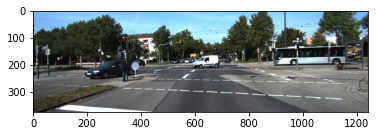

Máscara predecida:


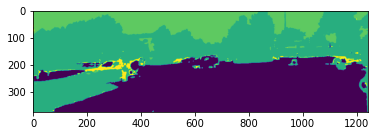

Máscara real:


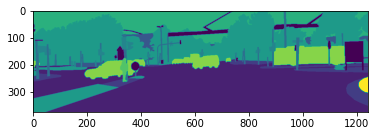

Imagen:  000142_10.png
Imagen RGB:


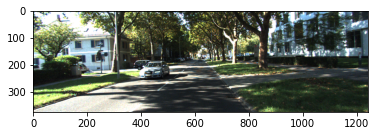

Máscara predecida:


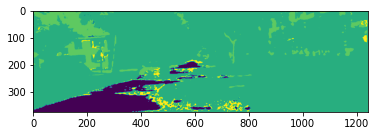

Máscara real:


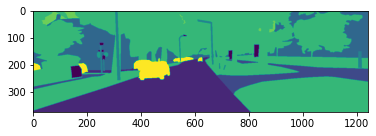

Imagen:  000017_10.png
Imagen RGB:


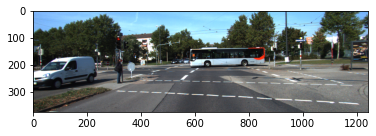

Máscara predecida:


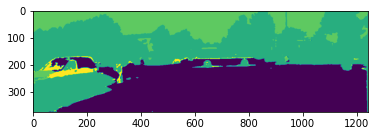

Máscara real:


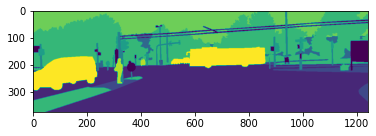

Imagen:  000001_10.png
Imagen RGB:


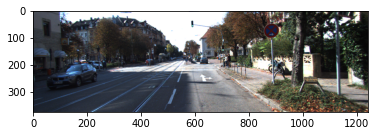

Máscara predecida:


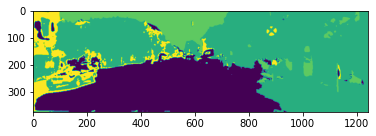

Máscara real:


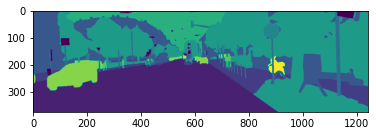

Imagen:  000108_10.png
Imagen RGB:


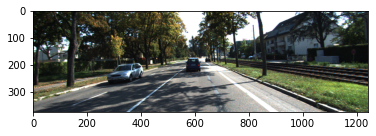

Máscara predecida:


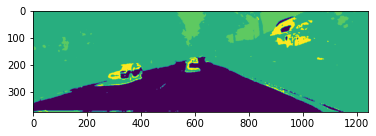

Máscara real:


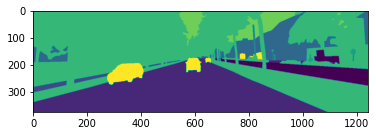

time: 3.58 s (started: 2021-01-08 01:24:25 +00:00)


In [ ]:
Epoca_Obj = 2
Predicted_Masks_Train_2 = []
net.load_state_dict(torch.load('CP_epoch'+str(Epoca_Obj)+'.pth'))
for i in Random_Indices_Train:  
  print('Imagen: ', os.listdir(dir_img)[int(i)])
  Img_Obj = train_dataset.__getitem__(int(i))['image']
  print('Imagen RGB:')
  plt.imshow(np.transpose(Img_Obj,[1,2,0]))
  plt.show()
  Mask_Obj = train_dataset.__getitem__(int(i))['mask']
  Img_Predecida = predict_img(net=net,full_img=Img_Obj, device=cuda)
  Predicted_Masks_Train_2.append(Img_Predecida)
  print('Máscara predecida:')
  plt.imshow(Img_Predecida)
  plt.show()
  print('Máscara real:')
  plt.imshow(Mask_Obj)
  plt.show()

### Predicción para imágenes del conjunto de entrenamiento con checkpoint de 7ma época 

Imagen:  000015_10.png
Imagen RGB:


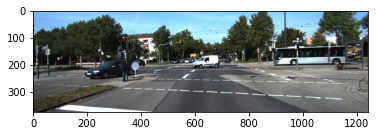

Máscara predecida:


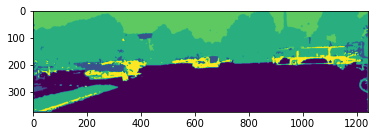

Máscara real:


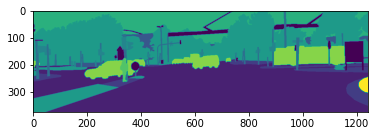

Imagen:  000142_10.png
Imagen RGB:


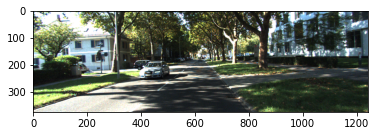

Máscara predecida:


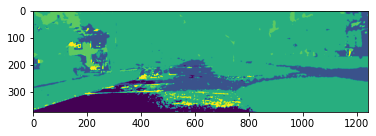

Máscara real:


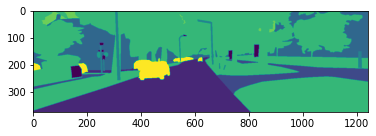

Imagen:  000017_10.png
Imagen RGB:


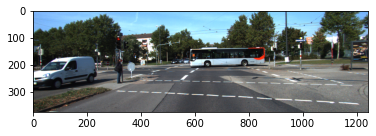

Máscara predecida:


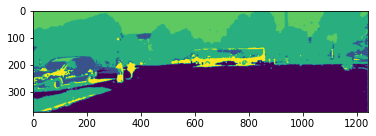

Máscara real:


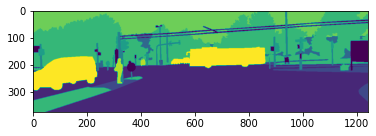

Imagen:  000001_10.png
Imagen RGB:


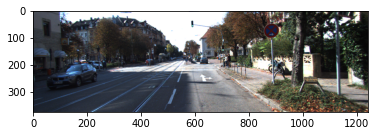

Máscara predecida:


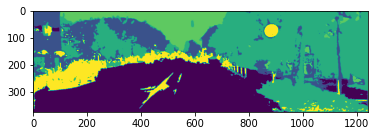

Máscara real:


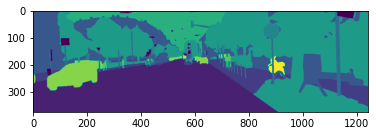

Imagen:  000108_10.png
Imagen RGB:


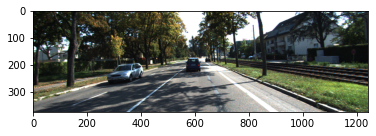

Máscara predecida:


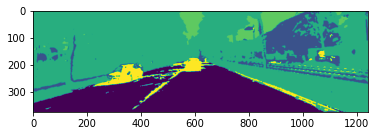

Máscara real:


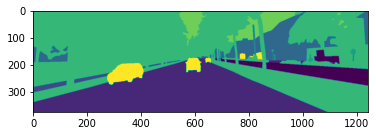

time: 3.73 s (started: 2021-01-08 01:24:52 +00:00)


In [ ]:
Epoca_Obj = 7
Predicted_Masks_Train_7 = []
net.load_state_dict(torch.load('CP_epoch'+str(Epoca_Obj)+'.pth'))
for i in Random_Indices_Train:  
  print('Imagen: ', os.listdir(dir_img)[int(i)])
  Img_Obj = train_dataset.__getitem__(int(i))['image']
  print('Imagen RGB:')
  plt.imshow(np.transpose(Img_Obj,[1,2,0]))
  plt.show()
  Mask_Obj = train_dataset.__getitem__(int(i))['mask']
  Img_Predecida = predict_img(net=net,full_img=Img_Obj, device=cuda)
  Predicted_Masks_Train_7.append(Img_Predecida)
  print('Máscara predecida:')
  plt.imshow(Img_Predecida)
  plt.show()
  print('Máscara real:')
  plt.imshow(Mask_Obj)
  plt.show()

### Predicción para imágenes del conjunto de prueba con checkpoint de 2da época 

In [ ]:
Random_Indices_Test = random.sample(list(Lista_Indices_Test), 5)

Imagen:  000008_10.png
Imagen RGB:


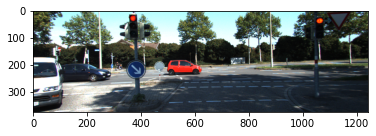

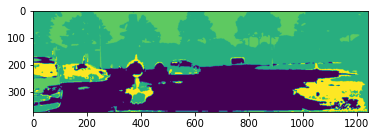

Imagen:  000169_10.png
Imagen RGB:


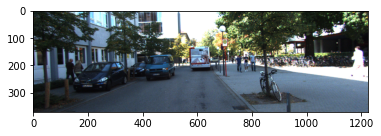

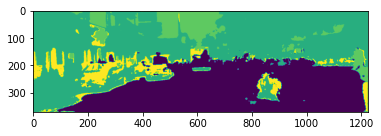

Imagen:  000024_10.png
Imagen RGB:


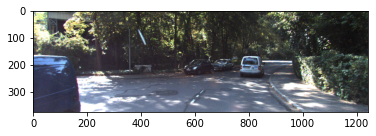

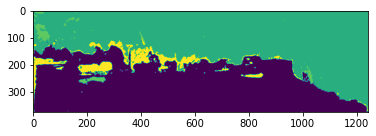

Imagen:  000184_10.png
Imagen RGB:


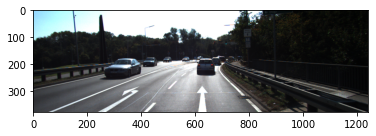

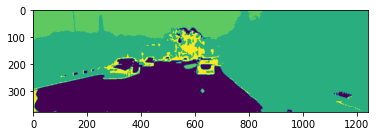

Imagen:  000080_10.png
Imagen RGB:


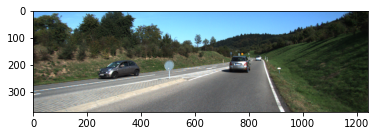

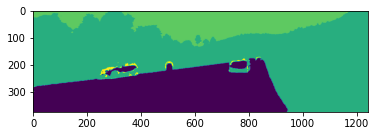

time: 2.6 s (started: 2021-01-08 01:25:17 +00:00)


In [ ]:
Epoca_Obj = 2
Predicted_Masks_Test_2 = []
net.load_state_dict(torch.load('CP_epoch'+str(Epoca_Obj)+'.pth'))
for i in Random_Indices_Test:  
  print('Imagen: ', os.listdir(dir_testing)[int(i)])
  Img_Test = test_dataset.__getitem__(int(i))['image']
  print('Imagen RGB:')
  plt.imshow(np.transpose(Img_Test,[1,2,0]))
  plt.show()
  Img_Predecida = predict_img(net=net,full_img=Img_Test, device=cuda)
  Predicted_Masks_Test_2.append(Img_Predecida)
  plt.imshow(Img_Predecida)
  plt.show()

### Predicción para imágenes del conjunto de prueba con checkpoint de 7ma época 

Imagen:  000008_10.png
Imagen RGB:


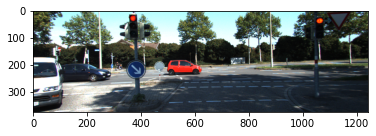

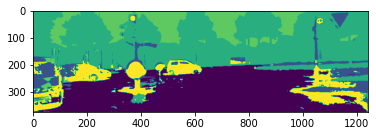

Imagen:  000169_10.png
Imagen RGB:


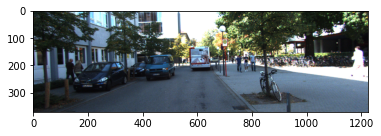

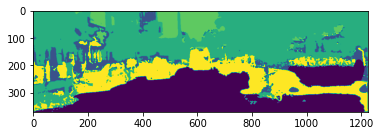

Imagen:  000024_10.png
Imagen RGB:


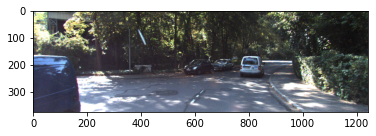

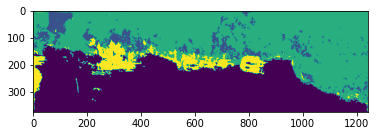

Imagen:  000184_10.png
Imagen RGB:


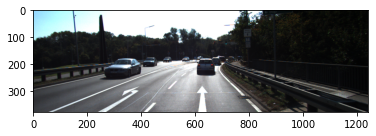

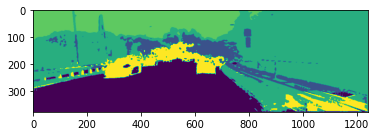

Imagen:  000080_10.png
Imagen RGB:


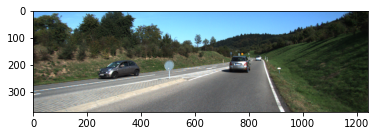

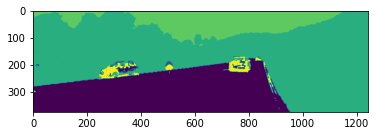

time: 2.68 s (started: 2021-01-08 01:25:43 +00:00)


In [ ]:
Epoca_Obj = 7
Predicted_Masks_Test_7 = []
net.load_state_dict(torch.load('CP_epoch'+str(Epoca_Obj)+'.pth'))
for i in Random_Indices_Test:  
  print('Imagen: ', os.listdir(dir_testing)[int(i)])
  Img_Test = test_dataset.__getitem__(int(i))['image']
  print('Imagen RGB:')
  plt.imshow(np.transpose(Img_Test,[1,2,0]))
  plt.show()
  Img_Predecida = predict_img(net=net,full_img=Img_Test, device=cuda)
  Predicted_Masks_Test_7.append(Img_Predecida)
  plt.imshow(Img_Predecida)
  plt.show()

# Análisis

Se presenta a continuación una comparación entre las máscaras predecidas para el conjunto de entrenamiento, tanto para dos épocas de entrenamiento de la red como para 7 épocas de entrenamiento de la red:

Imagen:  000015_10.png
Imagen RGB:


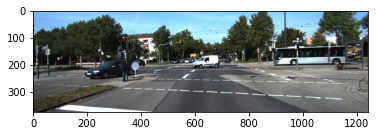

Máscara con 2 épocas de entrenamiento:


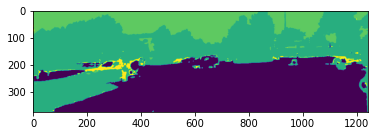

Máscara con 7 épocas de entrenamiento:


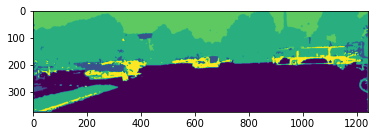

Máscara real:


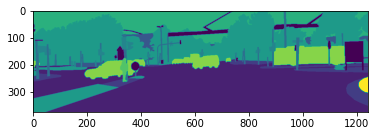

--------------------------------
Imagen:  000142_10.png
Imagen RGB:


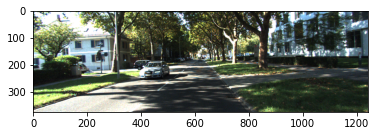

Máscara con 2 épocas de entrenamiento:


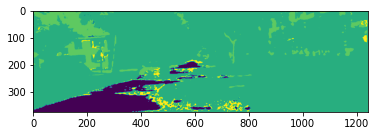

Máscara con 7 épocas de entrenamiento:


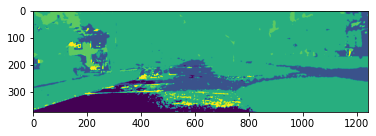

Máscara real:


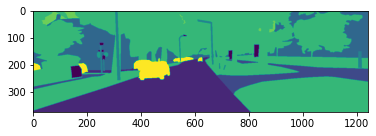

--------------------------------
Imagen:  000017_10.png
Imagen RGB:


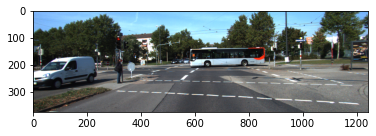

Máscara con 2 épocas de entrenamiento:


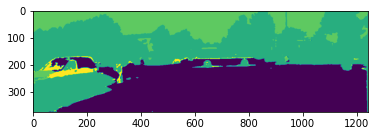

Máscara con 7 épocas de entrenamiento:


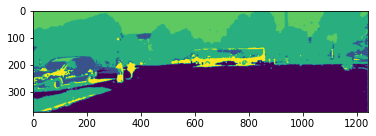

Máscara real:


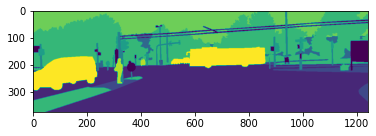

--------------------------------
Imagen:  000001_10.png
Imagen RGB:


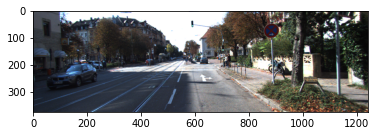

Máscara con 2 épocas de entrenamiento:


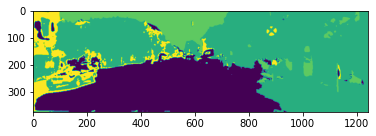

Máscara con 7 épocas de entrenamiento:


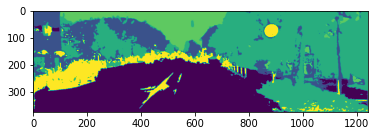

Máscara real:


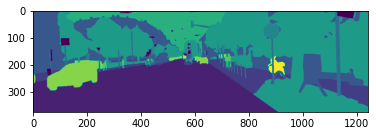

--------------------------------
Imagen:  000108_10.png
Imagen RGB:


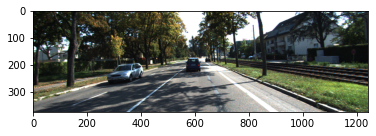

Máscara con 2 épocas de entrenamiento:


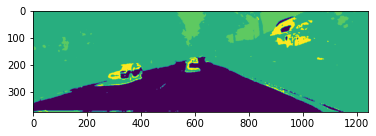

Máscara con 7 épocas de entrenamiento:


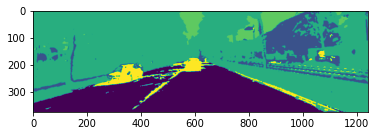

Máscara real:


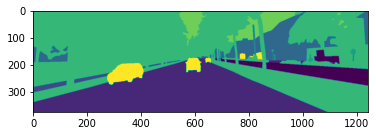

--------------------------------
time: 3.72 s (started: 2021-01-08 01:35:48 +00:00)


In [ ]:
for i,j,k in zip(Predicted_Masks_Train_2,Predicted_Masks_Train_7,Random_Indices_Train):
  print('Imagen: ', os.listdir(dir_img)[int(k)])
  print('Imagen RGB:')
  plt.imshow(np.transpose(train_dataset.__getitem__(int(k))['image'],[1,2,0]))
  plt.show()
  print('Máscara con 2 épocas de entrenamiento:')
  plt.imshow(i)
  plt.show()
  print('Máscara con 7 épocas de entrenamiento:')
  plt.imshow(j)
  plt.show()
  print('Máscara real:')
  plt.imshow(train_dataset.__getitem__(int(k))['mask'])
  plt.show()
  print('--------------------------------')

En las imágenes es posible observar que, la red con 2 épocas de entrenamiento ofrece baja distinción de los objetos que se visualizan, distinguiendo con baja calidad entre la calle y los vehículos y transeúntes; en contraste, con 7 épocas es mucho más notoria la diferenciación semántica, pudiendo distinguir de manera más precisa entre la calle y vehículos. Es posible observar que los resultados con entrenamiento de 7 épocas son mucho más cercanos a lo observado en las máscaras "ground truth", lo cual permite ilustrar el buen desempeño que posee la red para elaborar esta diferenciación semántica; sin embargo, esta no es perfecta, ya que se aprecia que, si bien la precisión es relativamente elevada para elementos que se encuentran cerca, a medida que se aumenta la distancia de los objetivos, la diferenciación semántica pierde resolución. Además, es posible observar que, si bien distingue entre vehículos y la calle, posee una baja precisión en distinguir entre vehículos que se encuentran relativamente juntos. Por otra parte, es posible observar en ambos casos que se determina con notable precisión que sección de la imagen corresponde al cielo y a árboles, principalmente a la distancia, lo cual se atribuye a lo distinto de las características de estos elementos con respecto a los vehículos y a la calle. Además, para 7 épocas, logra identificar si se presenta o no señales de tránsito, lo cual es fundamental para la implementación de este sistema en vehículos autónomos.

Se presenta a continuación una comparación entre las máscaras predecidas para el conjunto de prueba, tanto para dos épocas de entrenamiento de la red como para 7 épocas de entrenamiento de la red:

Imagen:  000008_10.png
Imagen RGB:


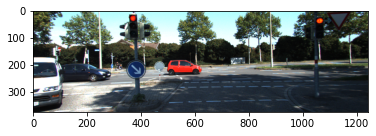

Máscara con 2 épocas de entrenamiento:


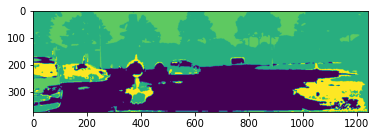

Máscara con 7 épocas de entrenamiento:


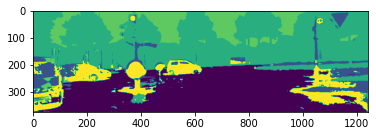

--------------------------------
Imagen:  000169_10.png
Imagen RGB:


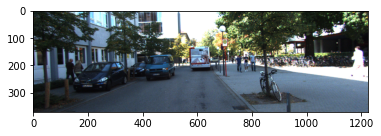

Máscara con 2 épocas de entrenamiento:


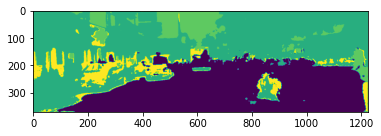

Máscara con 7 épocas de entrenamiento:


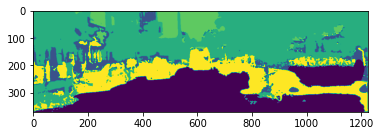

--------------------------------
Imagen:  000024_10.png
Imagen RGB:


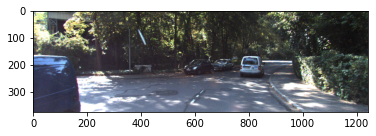

Máscara con 2 épocas de entrenamiento:


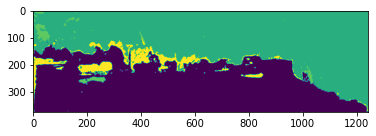

Máscara con 7 épocas de entrenamiento:


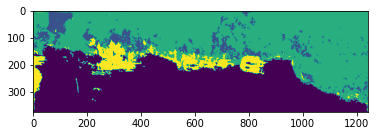

--------------------------------
Imagen:  000184_10.png
Imagen RGB:


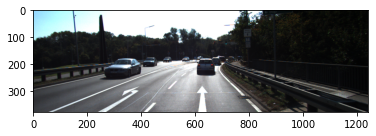

Máscara con 2 épocas de entrenamiento:


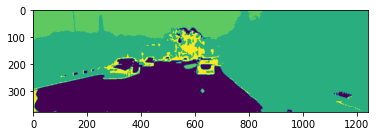

Máscara con 7 épocas de entrenamiento:


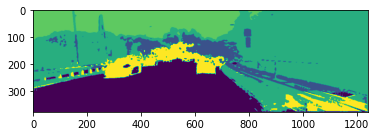

--------------------------------
Imagen:  000080_10.png
Imagen RGB:


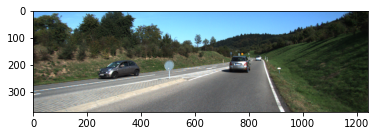

Máscara con 2 épocas de entrenamiento:


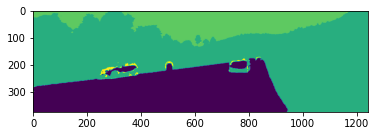

Máscara con 7 épocas de entrenamiento:


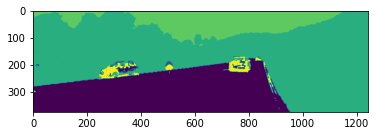

--------------------------------
time: 2.78 s (started: 2021-01-08 01:27:22 +00:00)


In [ ]:
for i,j,k in zip(Predicted_Masks_Test_2,Predicted_Masks_Test_7,Random_Indices_Test):
  print('Imagen: ', os.listdir(dir_testing)[int(k)])
  print('Imagen RGB:')
  plt.imshow(np.transpose(test_dataset.__getitem__(int(k))['image'],[1,2,0]))
  plt.show()
  print('Máscara con 2 épocas de entrenamiento:')
  plt.imshow(i)
  plt.show()
  print('Máscara con 7 épocas de entrenamiento:')
  plt.imshow(j)
  plt.show()
  print('--------------------------------')

Es posible apreciar que, al igual que en el caso anterior, la distinción entre elementos es mayor para el entrenamiento con 7 épocas que para el entrenamiento con 2 épocas. Se observa que para las 7 épocas identifica con muy alta precisión que sección corresponde a la calle, determinando también si se visualizan vehículos a corta y media distancia. Sin embargo, al igual que para el caso de las imágenes de entrenamiento, la distinción a larga distancia pierde precisión, además que no se ofrece una distinción clara entre los tipos de objetos (como vehículos, transeuntes, entre otros). Por otra parte, al igual que en el caso anterior, es posible observar en ambos casos que se determina con notable precisión que sección de la imagen corresponde al cielo y a árboles, principalmente a la distancia, lo cual se atribuye a lo distinto de las características de estos elementos con respecto a los vehículos y a la calle. Además, para 7 épocas, logra identificar si se presenta o no señales de tránsito, lo cual es fundamental para la implementación de este sistema en vehículos autónomos.

Si bien actualmente la red permite realizar distinciones semánticas, se espera que, con un mayor número de épocas, la precisión de la red mejore, permitiendo distinguir de manera más definida a los vehículos y a transeúntes.

# Conclusiones
En esta actividad se logró implementar con éxito la red U-Net para realizar una evaluación de segmentación semántica, permitiendo realizar una distinción de elementos en una secuencia de imágenes grabada por un vehículo en movimiento. Los resultados permiten observar que, bajo 2 épocas de entrenamiento, la red es capaz de distinguir la calle entre los objetos, mientras que, al entrenarse la red por 7 épocas, ya es capaz de distinguir con mayor precisión vehículos; sin embargo, estos resultados no son perfectos, siendo observable una pérdida de precisión con objetos más lejanos, o en el caso de objetos de un mismo tipo que se encuentran cerca uno del otro. 

Los resultados obtenidos se encuentran dentro de lo esperado teóricamente, por lo que se considera los objetivos respecto a la diferenciación semántica como cumplidos. Cabe destacar que no se observó sobreajuste de los datos al entrenarse la red por 7 épocas, por lo que se considera dicha instancia como la mejor entre ambas iteraciones (2 épocas y 7 épocas).

Los aprendizajes adquiridos en esta tarea consistieron en la experiencia al implementar correctamente la red U-Net para procesar una secuencia de imágenes en base a contexto, **entregando una herramienta que permitiría, entre otras aplicaciones, contribuir a la navegación de vehículos autónomos**. Las dificultades presentes en la experiencia consistieron en la implementación en términos de código de las funciones utilizadas y la red, siendo la mayor parte del tiempo empleado en la actividad la correcta implementación de estas.

Por último, se plantea que el desempeño de la red mejorará al aumentar el número de épocas de entrenamiento, permitiendo una mejor precisión en la diferenciación de elementos dado los problemas comentados anteriormente.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Tarea_6_EL7008.ipynb

[NbConvertApp] Converting notebook /content/Tarea_6_EL7008.ipynb to html
[NbConvertApp] Writing 5492814 bytes to /content/Tarea_6_EL7008.html


time: 1.69 s (started: 2021-01-08 02:24:14 +00:00)
